In [11]:
sentences = ["我 喜欢 玩具",
             "我 爱 爸爸",
             "我 讨厌 挨打"]

words_list = list(set(" ".join(sentences).split()))
word_to_idx = {word: idx for idx, word in enumerate(words_list)}
idx_to_word = {idx: word for idx, word in enumerate(words_list)}
voc_size = len(words_list)
print("词汇表：", words_list)
print("词汇到索引的字典", word_to_idx)
print("索引到词汇的字典", idx_to_word)
print("词汇表大小：", voc_size)


词汇表： ['爱', '讨厌', '爸爸', '我', '玩具', '挨打', '喜欢']
词汇到索引的字典 {'爱': 0, '讨厌': 1, '爸爸': 2, '我': 3, '玩具': 4, '挨打': 5, '喜欢': 6}
索引到词汇的字典 {0: '爱', 1: '讨厌', 2: '爸爸', 3: '我', 4: '玩具', 5: '挨打', 6: '喜欢'}
词汇表大小： 7


In [13]:
import torch
import random
batch_size = 2
def make_batch():
    input_batch = []
    target_batch = []
    selected_sentences = random.sample(sentences, batch_size)
    for sentence in selected_sentences:
        words = sentence.split()
        input_data = [word_to_idx[word] for word in words[:-1]]
        target = word_to_idx[words[-1]]
        input_batch.append(input_data)
        target_batch.append(target)
    return torch.LongTensor(input_batch), torch.LongTensor(target_batch)

input_batch, target_batch = make_batch()
print("input_batch:", input_batch)
print("target_batch:", target_batch)
input_words = []
for input_idx in input_batch:
    input_words.append(idx_to_word[idx.item()] for idx in input_idx)
print("input_words:", input_words)
print("target_batch:", target_batch)
target_words = [idx_to_word[idx.item()] for idx in target_batch]
print("target_words:", target_words)

input_batch: tensor([[3, 1],
        [3, 0]])
target_batch: tensor([5, 2])
input_words: [<generator object <genexpr> at 0x10d9a2c10>, <generator object <genexpr> at 0x12ebe9c80>]
target_batch: tensor([5, 2])
target_words: ['挨打', '爸爸']


In [15]:
import torch.nn as nn
class NPLM(nn.Module):
    def __init__(self, embedding_size, n_steps, n_hidden):
        super(NPLM, self).__init__()
        self.C = nn.Embedding(voc_size, embedding_size)
        self.linear1 = nn.Linear(n_steps * embedding_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, voc_size)
        self.embedding_size = embedding_size
        self.n_steps = n_steps
    def forward(self, x):
        x = self.C(x)
        x = x.view(-1, self.n_steps * self.embedding_size)
        hidden = torch.tanh(self.linear1(x))
        output = self.linear2(hidden)
        return output
    
model = NPLM(2, 2, 2)
print(model)

NPLM(
  (C): Embedding(7, 2)
  (linear1): Linear(in_features=4, out_features=2, bias=True)
  (linear2): Linear(in_features=2, out_features=7, bias=True)
)


Epoch: 0100 cost = 0.286794
Epoch: 0200 cost = 0.203377
Epoch: 0300 cost = 0.180875
Epoch: 0400 cost = 0.097134
Epoch: 0500 cost = 0.087334
Epoch: 0600 cost = 0.077545
Epoch: 0700 cost = 0.070148
Epoch: 0800 cost = 0.104724
Epoch: 0900 cost = 0.057973
Epoch: 1000 cost = 0.086309
Epoch: 1100 cost = 0.048018
Epoch: 1200 cost = 0.071688
Epoch: 1300 cost = 0.066500
Epoch: 1400 cost = 0.037771
Epoch: 1500 cost = 0.054242
Epoch: 1600 cost = 0.052119
Epoch: 1700 cost = 0.045628
Epoch: 1800 cost = 0.042307
Epoch: 1900 cost = 0.042079
Epoch: 2000 cost = 0.038982
Epoch: 2100 cost = 0.036357
Epoch: 2200 cost = 0.033973
Epoch: 2300 cost = 0.029266
Epoch: 2400 cost = 0.018495
Epoch: 2500 cost = 0.025575
Epoch: 2600 cost = 0.016514
Epoch: 2700 cost = 0.015497
Epoch: 2800 cost = 0.023063
Epoch: 2900 cost = 0.013941
Epoch: 3000 cost = 0.020130
Epoch: 3100 cost = 0.012358
Epoch: 3200 cost = 0.016124
Epoch: 3300 cost = 0.015110
Epoch: 3400 cost = 0.016146
Epoch: 3500 cost = 0.015206
Epoch: 3600 cost = 0

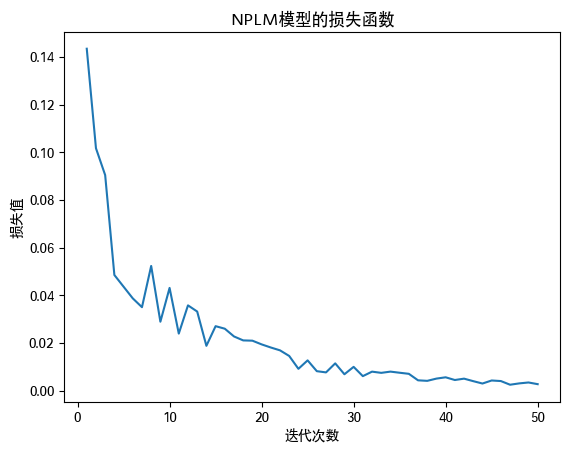

In [18]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []
for epoch in range(5000):
    input_batch, target_batch = make_batch()
    optimizer.zero_grad()
    output = model(input_batch)
    loss = criterion(output, target_batch)
    if (epoch + 1) % 100 == 0:
        print("Epoch:", "%04d" % (epoch + 1), "cost =", "{:.6f}".format(loss.item()))
        losses.append(loss.item()/batch_size)
    loss.backward()
    optimizer.step()

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Hei']
plt.rcParams['font.sans-serif'] = ['Hei']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(range(1, 5000//100 + 1), losses)
plt.title('NPLM模型的损失函数')
plt.xlabel('迭代次数')
plt.ylabel('损失值')
plt.show()

In [19]:
input_strs = [['我', '讨厌'],['我', '喜欢']]
input_indices = [[word_to_idx[word] for word in input_str] for input_str in input_strs]
input_batch = torch.LongTensor(input_indices)
predict = model(input_batch)
predict = predict.data.max(1, keepdim=True)[1]
print("input_strs:", input_strs)
print("predict:", predict)
predict_words = []
for idx in predict:
    predict_words.append(idx_to_word[idx.item()])
print("predict_words:", predict_words)

input_strs: [['我', '讨厌'], ['我', '喜欢']]
predict: tensor([[5],
        [4]])
predict_words: ['挨打', '玩具']
